# Quick Start - Raster Query

In this section, we build upon the [Quickstart Point Query](quickstartpointquery.ipynb) guide and consider raster queries defined over areas. I.e., where that tutorial only dealt with point queries, we will now request data over extended areas.

## Basic Raster Queries

Once gain, we start with a minimal working example. Namely, we will request NDVI data from the Sentinel 2 l2a satellite. The *Normalized Difference Vegetation Index*, [NDVI](https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index) for short, indicates the amount of vegetation present at the location and time in question. It is calculated from both the near infrared and red bands, takes values between 0 and 1 and has many uses across a wide range of remote-sensing applications. The Sentinel 2 l2a satellite produces a raster image of a particular location approximately once every 5 days.

Since point queries are quick, it is generally a good idea to launch a point query first if working in an interactive environment such as Jupyter or R-studio. Note that we are requesting a single timestamp using ``snapshot``.

In [1]:
import os
import pandas as pd
import ibmpairs.authentication as authentication
import ibmpairs.client as client
import ibmpairs.query as query

# Best practice is not to include secrets in source code so we read 
# an api key, tenant id and org id from operating system environment 
# variables. You could set the credentials in-line here but we don't 
# recommend it for security reasons.
EIS_API_KEY   = os.environ.get('EIS_API_KEY')
EIS_TENANT_ID = os.environ.get('EIS_TENANT_ID')
EIS_ORG_ID    = os.environ.get('EIS_ORG_ID')

# Authenticate and get a client object.
eis_client = client.get_client(api_key   = EIS_API_KEY,
                               tenant_id = EIS_TENANT_ID,
                               org_id    = EIS_ORG_ID,
                               legacy    = False)

query_json = {
      "layers" : [
          {"type" : "raster", "id" : "49464"}
      ],
      "spatial" : {
          "type" : "point",
          "coordinates" : ["50.92163290389907", "-1.4837586747526244"]
      },
      "temporal" : {"intervals" : [
          {"snapshot" : "2021-05-10T00:00:00Z"}
      ]}
  }

# Submit the query
query_result = query.submit(query_json)

# Convert the results to a dataframe
point_df = query_result.point_data_as_dataframe()
# Convert the timestamp to a human readable format
point_df['datetime'] = pd.to_datetime(point_df['timestamp'] * 1e6, errors = 'coerce')
point_df

2023-08-15 09:42:14 - paw - INFO - The client authentication method is assumed to be OAuth2.
2023-08-15 09:42:14 - paw - INFO - Legacy Environment is False
2023-08-15 09:42:16 - paw - INFO - Authentication success.
2023-08-15 09:42:16 - paw - INFO - HOST: https://api.ibm.com/geospatial/run/na/core/v3
2023-08-15 09:42:16 - paw - INFO - TASK: submit STARTING.
2023-08-15 09:42:47 - paw - INFO - TASK: submit COMPLETED.


,layer_id,layer_name,dataset,timestamp,longitude,latitude,value,datetime
0,49464,Normalized difference vegetation index,High res imagery (ESA Sentinel 2),1606867200000,-1.483759,50.921633,-0.0121,2020-12-02
1,49464,Normalized difference vegetation index,High res imagery (ESA Sentinel 2),1607126400000,-1.483759,50.921633,0.1069,2020-12-05
2,49464,Normalized difference vegetation index,High res imagery (ESA Sentinel 2),1607299200000,-1.483759,50.921633,0.013100000000000112,2020-12-07
3,49464,Normalized difference vegetation index,High res imagery (ESA Sentinel 2),1607558400000,-1.483759,50.921633,0.0038000000000000256,2020-12-10
4,49464,Normalized difference vegetation index,High res imagery (ESA Sentinel 2),1607731200000,-1.483759,50.921633,0.17470000000000008,2020-12-12
...,...,...,...,...,...,...,...,...
58,49464,Normalized difference vegetation index,High res imagery (ESA Sentinel 2),1619654400000,-1.483759,50.921633,-0.0010999999999999899,2021-04-29
59,49464,Normalized difference vegetation index,High res imagery (ESA Sentinel 2),1619827200000,-1.483759,50.921633,0.18440000000000012,2021-05-01
60,49464,Normalized difference vegetation index,High res imagery (ESA Sentinel 2),1620086400000,-1.483759,50.921633,0.2752000000000001,2021-05-04
61,49464,Normalized difference vegetation index,High res imagery (ESA Sentinel 2),1620259200000,-1.483759,50.921633,0.11519999999999997,2021-05-06


Since we requested only a ``snapshot``, Geospatial Analytics returns only the closest matching timestamp. Note how the timestamp returned does not match the one we requested. Clearly, there is no data on 2021-05-10 and PAIRS returns the closest match. (As an exercise, one could verify this by requesting an actual interval) 

As a matter of fact, let us do a bit more and discuss the details later. The following code snippet submits the query to Geospatial Analytics, waits for it to finish, downloads the data to the ``download`` folder, loads the data to memory and displays it on screen. This could take a few minutes to complete as all the data is brought together. 

In [2]:
import PIL.Image
import numpy as np
import matplotlib.pyplot as plt

query_json = {
      "layers" : [
          {"type" : "raster", "id" : "49464"}
      ],
      "spatial" : {
          "type" : "square",
          "coordinates" : ["50.894788495590255", "-1.5016114579557494", "50.93353474215812", "-1.440843330514343"]
      },
      "temporal" : {"intervals" : [
          {"snapshot" : "2023-05-09T00:00:00Z"}
      ]}
  }

# Submit the query
query_result = query.submit_check_status_and_download(query_json)

# Find layer files to load from downloaded zip.
files = query_result.list_files()
print("Downloaded file = '" + os.path.basename(files[0]) + "'")

2023-08-15 09:42:48 - paw - INFO - TASK: submit_check_status_and_download STARTING.
2023-08-15 09:42:48 - paw - INFO - The query was successfully submitted with the id: 1692057600_31368695.
2023-08-15 09:42:49 - paw - INFO - The query 1692057600_31368695 has the status Queued.
2023-08-15 09:43:19 - paw - INFO - The query 1692057600_31368695 has the status Running.
2023-08-15 09:43:50 - paw - INFO - The query 1692057600_31368695 has the status Succeeded.
2023-08-15 09:43:50 - paw - INFO - The query 1692057600_31368695 was successful after checking the status.
2023-08-15 09:44:21 - paw - INFO - The query 1692057600_31368695 has the status Succeeded.
2023-08-15 09:44:21 - paw - INFO - The query 1692057600_31368695 was successful after checking the status.
2023-08-15 09:44:21 - paw - INFO - The query download folder is set to the path /Users/ibmpairs/tutorials/notebooks/quickstart/download/.
2023-08-15 09:44:22 - paw - INFO - The query zip for 1692057600_31368695 will be downloaded to the 

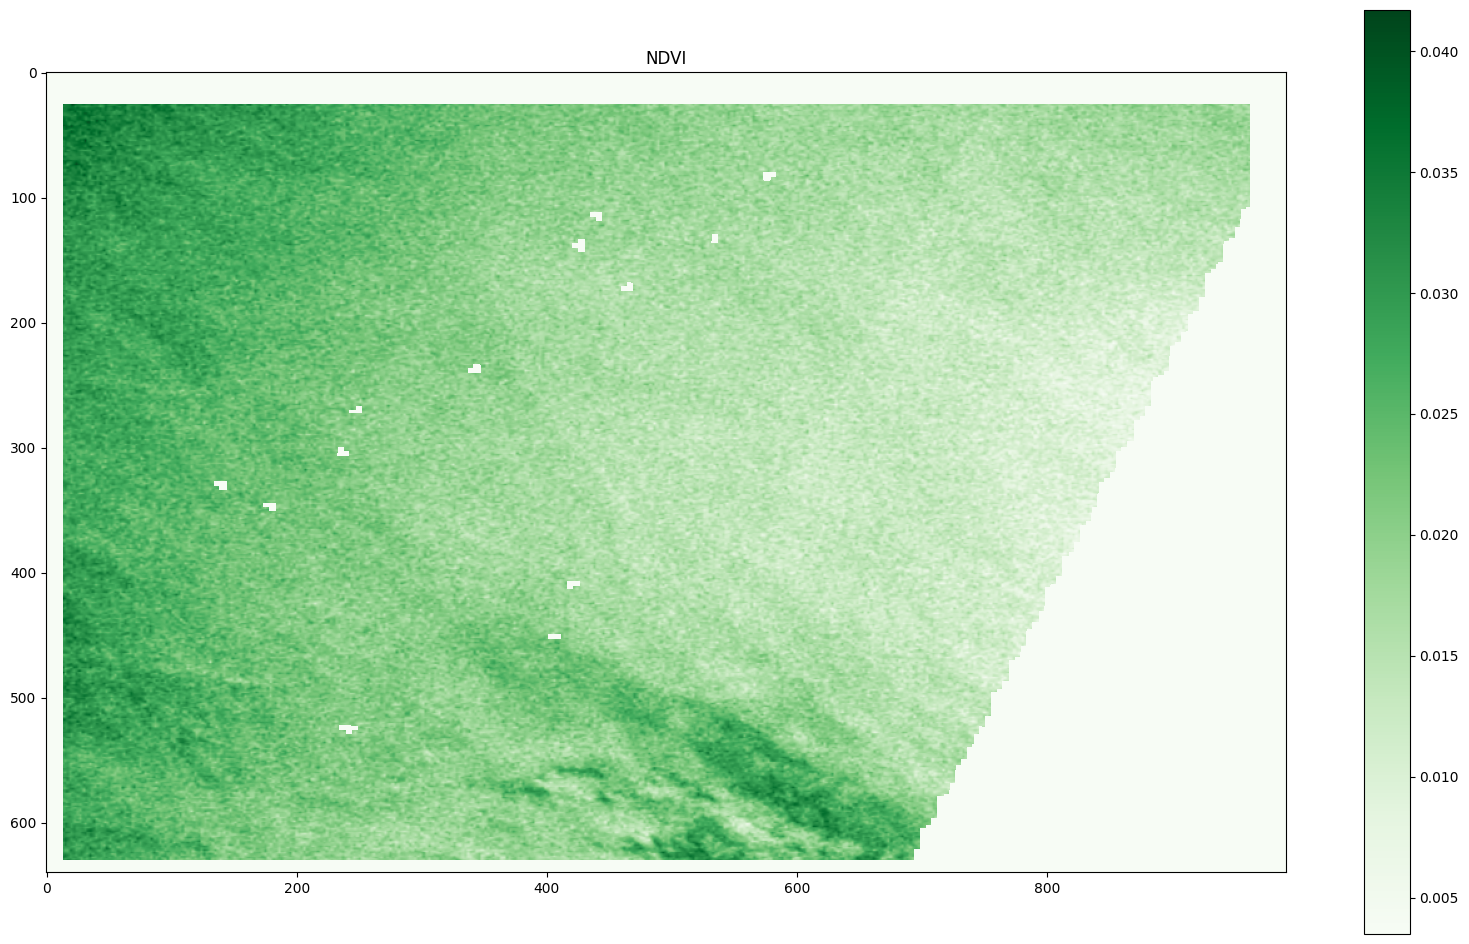

In [3]:
array = np.array(PIL.Image.open(files[0]))
plt.figure(figsize = (20, 12))
plt.imshow(array, cmap = 'Greens', vmin = 0.0035, vmax = 0.0417)
plt.title('NDVI')
plt.colorbar()
plt.show()

<div class="alert alert-info">
Raster data in Geospatial Analytics is stored at specific resolutions, which are referred to as Geospatial Analytics levels. Going from one level to the next increases the resolution by a factor of 2. Generally, the resolution of a Geospatial Analytics layer in degrees latitude and longitude is

$$
10^{-6} \times 2^{29-l}
$$

where l is the level. Each layer's level can be found by searching the catalog.

Since the Geospatial Analytics grid is defined in terms of degrees latitude and longitude - the spatial reference system is WGS 84 which is also known as EPSG:4326 - the spatial resolution *in meters* depends on the location on the earth. Spatial resolution (in meters) along the east-west direction is coarsest at the equator and finest at the poles. Spatial resolution (in meters) along the north-south direction is constant and roughly equal to the east-west value at the equator. One can obtain the latter by considering the earth as a sphere with a circumference of 40,075 km.
</div>

## Understanding the Example

Let's go over the details of the above example, highlighting differences to the point queries we discussed previously. The changes to ``query_json`` are minimal. To turn our earlier point query into a query over an area, we simply modified the value of ``spatial`` key to ``square`` instead of ``point`` (note that ``square`` indicates a rectangular region). The coordinates describe a rectangular area in SWNE (South West North East) convention. We give the southernmost latitude, westernmost longitude, northernmost latitude, easternmost longitude in that order. As before, we pass the raw query JSON into the query object.

This time around however, submitting the query does not immediately return data because the raster area query takes time and its operation is asynchronous. In this case instead of ``query.submit(query_json)`` we use ``query.submit_check_status_and_download(query_json)``. This does what its name suggests and submits the query to Geospatial Analytics, checks the status of the query as it runs and, once complete, downloads the results of the query as a zip file.

You can see from the output of the call that ``query.submit_check_status_and_download(query_json)`` prints the status of the job as it progresses:

```
2021-12-03 17:29:49 - paw - INFO - The query was successfully submitted with the id: <query-id>.
2021-12-03 17:29:49 - paw - INFO - The query <query-id> has the status Queued.
2021-12-03 17:30:19 - paw - INFO - The query <query-id> has the status Initializing.
2021-12-03 17:30:50 - paw - INFO - The query <query-id> has the status Running.
2021-12-03 17:31:20 - paw - INFO - The query <query-id> has the status Running.
2021-12-03 17:31:51 - paw - INFO - The query <query-id> has the status Writing.
2021-12-03 17:32:21 - paw - INFO - The query <query-id> has the status Succeeded.
```

On the first line you can see the query ID that has been assigned by Geospatial Analytics to the query job. ``<query-id>`` will look something like "1638550800_01788995" and is unique for each query submitted to Geospatial Analytics. After this you can see the query transition through ``Queued``, ``Initializing``, ``Running``, ``Writing`` and finally ``Succeeded``. You won't necessarily see all of these stages printed out depending on how busy the Geospatial Analytics system is at the time you sumbit the query. 

Once processing is complete you can see that the resulting query zip file is placed in the download folder. This folder is usually placed inside the directory where you run this notebook from. For example, 

```
C:\<path>\<to>\<file>\downloads/<query-id>.zip.
```

The library will automatically unzip this zip file for you and into a directory named after the query ID. In this case the contents are as follows:

```
High res  imagery (ESA Sentinel 2)-Normalized difference vegetation index-05_09_2023T00_00_00.tiff
High res  imagery (ESA Sentinel 2)-Normalized difference vegetation index-05_09_2023T00_00_00.tiff.json
data_acknowledgement.txt
output.info
```

The .tiff file is the image for the rectangle and date we are expecting. The .tiff.json files holds metadata about the image:

```
{
    "pixelType":          "fl",
    "pixelNoDataVal":     -9999.000000,
    "spatialRef":         "EPSG:4326",
    "boundingBox":        {
            "minLatitude":    50.894208,
            "maxLatitude":    50.935168,
            "minLongitude":   -1.502464,
            "maxLongitude":   -1.438976
        },
    "pixelDimensions":    {
            "pixelSizeDegreeLongitude":   0.000064,
            "pixelSizeDegreeLatitude":    0.000064,
            "numberPixelsLatitude":       640,
            "numberPixelsLongitude":      992
        },
    "rasterStatistics":   {
            "pixelMin":               0.003500,
            "pixelMax":               0.041700,
            "pixelCount":             502966,
            "pixelMean":              0.019595,
            "pixelStandardDeviation": 0.005736
        }
}
```
The data_acknowledgement.txt file contains any acknowledgements associated with the data we provide. The output.info file maps the images files back to the Geospatial Analytics data layers that were used to produce them:
```
{
  "files": [
    {
      "datalayerId": "49464",
      "datalayerName": "Normalized difference vegetation index",
      "layerType": "raster",
      "name": "High res  imagery (ESA Sentinel 2)-Normalized difference vegetation index-05_09_2023T00_00_00",
      "timestamp": 1683590400000
    }
  ]
}
```

In this example we only use the .tiff file. We load the pixels into a numpy array using the Python Image Library (PIL). Then we display the numpy array using matplotlib. All standard Python techniques. Once images have been downloaded you can use any your favourite techniques to process them. 